XGBoost version: 3.0.2
Data shape: (2290, 6)
Date range: 2008-01-02 00:00:00 to 2018-05-16 00:00:00
Data after cleaning: (2287, 14)
Feature matrix shape: (2287, 7)
Target shape: (2287,)

Running 5-fold time series cross-validation...
Fold 1/5...
  Train R²: 0.926, Val R²: 0.602, Val RMSE: 0.0068
Fold 2/5...
  Train R²: 0.882, Val R²: 0.676, Val RMSE: 0.0071
Fold 3/5...
  Train R²: 0.865, Val R²: 0.716, Val RMSE: 0.0073
Fold 4/5...
  Train R²: 0.855, Val R²: 0.666, Val RMSE: 0.0061
Fold 5/5...
  Train R²: 0.840, Val R²: 0.713, Val RMSE: 0.0039

CROSS-VALIDATION RESULTS
Train R²: 0.873 (+/- 0.059)
Validation R²: 0.675 (+/- 0.082)
Validation RMSE: 0.0062 (+/- 0.0025)

Training final model on all data...


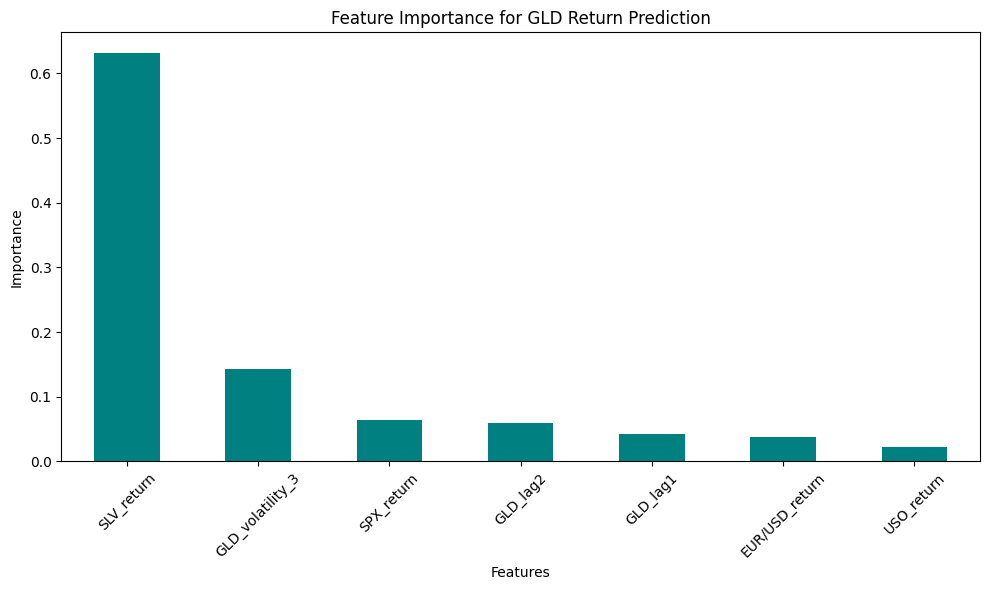


Feature Importance:
SLV_return: 0.632
GLD_volatility_3: 0.143
SPX_return: 0.065
GLD_lag2: 0.059
GLD_lag1: 0.042
EUR/USD_return: 0.037
USO_return: 0.023


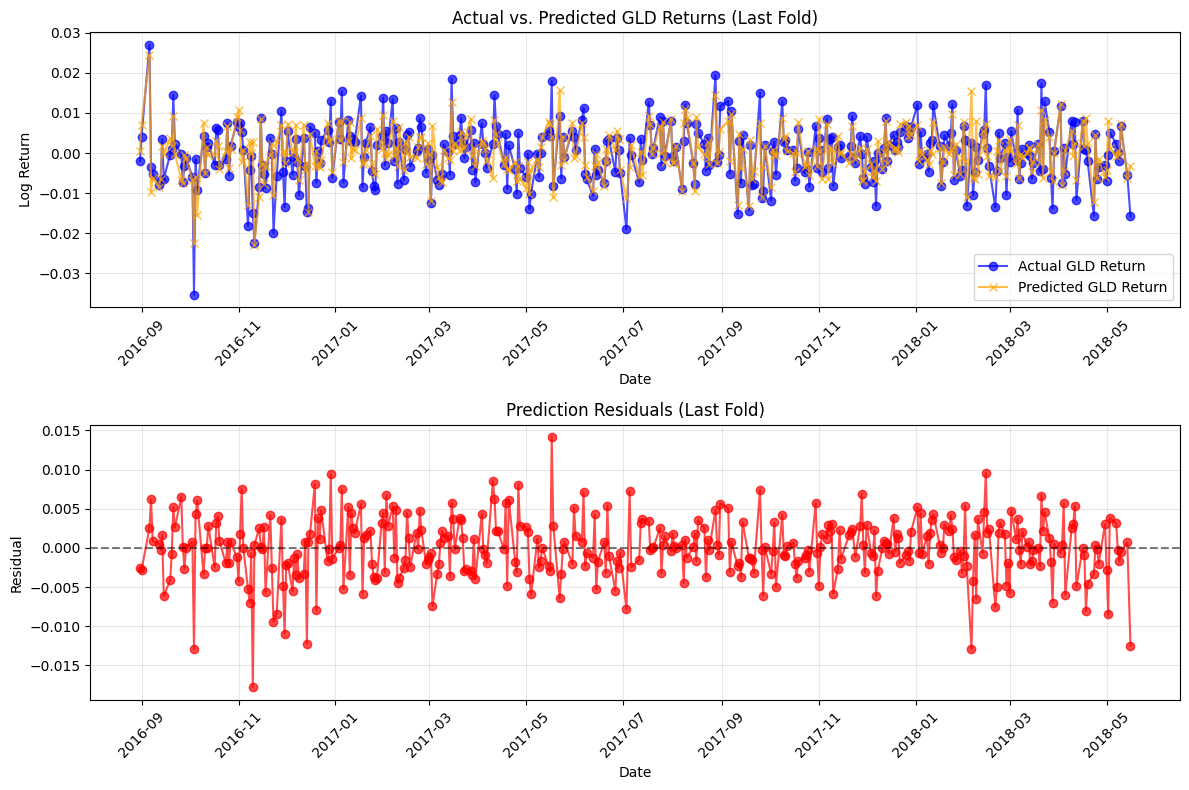


EXAMPLE PREDICTION

PREDICTION DETAILS:
Current GLD price: $87.50
Predicted log return: 0.0049 (0.49%)
Predicted GLD price: $87.93
Expected change: $0.43

PREDICTION FROM PRICE DATA

PREDICTION DETAILS:
Current GLD price: $87.50
Predicted log return: 0.0090 (0.90%)
Predicted GLD price: $88.29
Expected change: $0.79

MODEL READY FOR PREDICTIONS!
Use predict_gld_price() function with your current market data.


In [41]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, DMatrix, train
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Verify XGBoost version
print(f"XGBoost version: {xgb.__version__}")

# Load and prepare data
data = pd.read_csv('gld_price_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")

# Feature engineering: Convert to log returns
for col in ['GLD', 'SPX', 'USO', 'SLV', 'EUR/USD']:
    data[f'{col}_return'] = np.log(data[col] / data[col].shift(1))

# Add lagged features and rolling volatility
data['GLD_lag1'] = data['GLD_return'].shift(1)
data['GLD_lag2'] = data['GLD_return'].shift(2)
data['GLD_volatility_3'] = data['GLD_return'].rolling(window=3).std()

# Drop NaN values
data_clean = data.dropna().reset_index(drop=True)
print(f"Data after cleaning: {data_clean.shape}")

# Check if enough data remains
if len(data_clean) < 10:
    raise ValueError("Not enough data after preprocessing. Need at least 10 rows.")

# Define features and target
features = ['SPX_return', 'USO_return', 'SLV_return', 'EUR/USD_return', 'GLD_lag1', 'GLD_lag2', 'GLD_volatility_3']
X = data_clean[features]
y = data_clean['GLD_return']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize XGBoost model (compatible parameters)
model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=200,
    reg_lambda=2,
    random_state=42
)

# Time-series cross-validation
n_splits = min(5, len(data_clean) // 10)  # Ensure enough data per fold
tscv = TimeSeriesSplit(n_splits=n_splits)
train_r2_scores, val_r2_scores, val_rmse_scores = [], [], []

print(f"\nRunning {n_splits}-fold time series cross-validation...")

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    print(f"Fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Fit model with early stopping (compatible with all XGBoost versions)
    try:
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            early_stopping_rounds=10,
            verbose=False
        )
    except TypeError:
        # Fallback for older XGBoost versions
        model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Evaluate
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    val_rmse_scores.append(val_rmse)
    
    print(f"  Train R²: {train_r2:.3f}, Val R²: {val_r2:.3f}, Val RMSE: {val_rmse:.4f}")

# Print final results
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)
print(f"Train R²: {np.mean(train_r2_scores):.3f} (+/- {np.std(train_r2_scores) * 2:.3f})")
print(f"Validation R²: {np.mean(val_r2_scores):.3f} (+/- {np.std(val_r2_scores) * 2:.3f})")
print(f"Validation RMSE: {np.mean(val_rmse_scores):.4f} (+/- {np.std(val_rmse_scores) * 2:.4f})")

# Train final model on all data
print("\nTraining final model on all data...")
model_final = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=200,
    reg_lambda=2,
    random_state=42
)
model_final.fit(X_scaled, y)

# Plot feature importance
feature_importance = pd.Series(model_final.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='teal')
plt.title('Feature Importance for GLD Return Prediction')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.3f}")

# Plot actual vs. predicted for the last fold
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(data_clean['Date'].iloc[val_idx], y_val, label='Actual GLD Return', marker='o', color='blue', alpha=0.7)
plt.plot(data_clean['Date'].iloc[val_idx], val_pred, label='Predicted GLD Return', marker='x', color='orange', alpha=0.7)
plt.title('Actual vs. Predicted GLD Returns (Last Fold)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(2, 1, 2)
residuals = y_val - val_pred
plt.plot(data_clean['Date'].iloc[val_idx], residuals, marker='o', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Prediction Residuals (Last Fold)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PREDICTION FUNCTION FOR NEW DATA
def predict_gld_price(current_gld_price, market_returns, model, scaler, verbose=True):
    """
    Predict tomorrow's GLD price using trained returns model
    
    Parameters:
    -----------
    current_gld_price : float
        Today's GLD closing price
    market_returns : dict
        Dictionary with keys: 'SPX_return', 'USO_return', 'SLV_return', 'EUR/USD_return',
                             'GLD_lag1', 'GLD_lag2', 'GLD_volatility_3'
    model : trained XGBoost model
    scaler : fitted StandardScaler
    verbose : bool
        Print details
    
    Returns:
    --------
    float : Predicted GLD price for tomorrow
    """
    
    # Prepare features array
    features_array = np.array([[
        market_returns['SPX_return'],
        market_returns['USO_return'], 
        market_returns['SLV_return'],
        market_returns['EUR/USD_return'],
        market_returns['GLD_lag1'],
        market_returns['GLD_lag2'],
        market_returns['GLD_volatility_3']
    ]])
    
    # Scale the features
    features_scaled = scaler.transform(features_array)
    
    # Predict log return
    predicted_return = model.predict(features_scaled)[0]
    
    # Convert back to price: new_price = current_price * exp(predicted_return)
    predicted_price = current_gld_price * np.exp(predicted_return)
    
    if verbose:
        print(f"\nPREDICTION DETAILS:")
        print(f"Current GLD price: ${current_gld_price:.2f}")
        print(f"Predicted log return: {predicted_return:.4f} ({predicted_return*100:.2f}%)")
        print(f"Predicted GLD price: ${predicted_price:.2f}")
        print(f"Expected change: ${predicted_price - current_gld_price:.2f}")
    
    return predicted_price

# EXAMPLE USAGE
print("\n" + "="*50)
print("EXAMPLE PREDICTION")
print("="*50)

# Example: Predict using recent market data
current_gld = 87.50  # Today's GLD price

# Example market returns (you would calculate these from actual price data)
example_market_data = {
    'SPX_return': 0.005,      # SPX up 0.5%
    'USO_return': -0.010,     # USO down 1%
    'SLV_return': 0.008,      # SLV up 0.8%
    'EUR/USD_return': 0.001,  # EUR/USD up 0.1%
    'GLD_lag1': 0.003,        # Yesterday's GLD return (up 0.3%)
    'GLD_lag2': -0.002,       # Day before yesterday GLD return (down 0.2%)
    'GLD_volatility_3': 0.015 # 3-day rolling volatility
}

predicted_gld = predict_gld_price(current_gld, example_market_data, model_final, scaler)

# HELPER FUNCTION TO CALCULATE RETURNS FROM PRICES
def calculate_returns_from_prices(prices_dict):
    """
    Helper function to calculate returns if you have current and previous prices
    
    Parameters:
    -----------
    prices_dict : dict
        Dictionary with current and previous prices
        Example: {
            'SPX_current': 4500, 'SPX_previous': 4480,
            'USO_current': 75.0, 'USO_previous': 75.5,
            'SLV_current': 16.5, 'SLV_previous': 16.3,
            'EUR_USD_current': 1.482, 'EUR_USD_previous': 1.480,
            'GLD_lag1': 87.2, 'GLD_lag2': 87.0, 'GLD_lag3': 87.1,
            'GLD_volatility_3': 0.015
        }
    
    Returns:
    --------
    dict : Dictionary of returns ready for prediction
    """
    
    returns = {
        'SPX_return': np.log(prices_dict['SPX_current'] / prices_dict['SPX_previous']),
        'USO_return': np.log(prices_dict['USO_current'] / prices_dict['USO_previous']),
        'SLV_return': np.log(prices_dict['SLV_current'] / prices_dict['SLV_previous']),
        'EUR/USD_return': np.log(prices_dict['EUR_USD_current'] / prices_dict['EUR_USD_previous']),
        'GLD_lag1': np.log(prices_dict['GLD_lag1'] / prices_dict['GLD_lag2']),
        'GLD_lag2': np.log(prices_dict['GLD_lag2'] / prices_dict['GLD_lag3']),
        'GLD_volatility_3': prices_dict['GLD_volatility_3']
    }
    
    return returns

# Example using price data
print("\n" + "="*50)
print("PREDICTION FROM PRICE DATA")
print("="*50)

example_prices = {
    'SPX_current': 4500,
    'SPX_previous': 4480,
    'USO_current': 75.0,
    'USO_previous': 75.5,
    'SLV_current': 16.5,
    'SLV_previous': 16.3,
    'EUR_USD_current': 1.482,
    'EUR_USD_previous': 1.480,
    'GLD_lag1': 87.2,
    'GLD_lag2': 87.0,
    'GLD_lag3': 87.1,
    'GLD_volatility_3': 0.015
}

returns_from_prices = calculate_returns_from_prices(example_prices)
predicted_gld_from_prices = predict_gld_price(87.50, returns_from_prices, model_final, scaler)

print("\n" + "="*50)
print("MODEL READY FOR PREDICTIONS!")
print("Use predict_gld_price() function with your current market data.")
print("="*50)

In [38]:
pred

array([125.13570112])